In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install mplcyberpunk

In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import keras
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from tensorflow.keras import backend as K
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from tqdm import tqdm
import cv2
import mplcyberpunk
plt.style.use("cyberpunk")

2024-07-02 02:45:37.076785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 02:45:37.076915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 02:45:37.203997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
X_train = []
y_train = []
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

image_size=512
for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri/Training', i)
    for j in tqdm(os.listdir(folder_path)):
        img=cv2.imread(os.path.join(folder_path,j))
        img=cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri/Testing', i)
    for j in tqdm(os.listdir(folder_path)):
        img=cv2.imread(os.path.join(folder_path, j))
        img=cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 218.24it/s]


In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [16]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [16]:
def cnn_model():
    input_size = keras.Input(shape=(512, 512, 3), name='image')

    x1=layers.Conv2D(64,(22,22),strides=2)(input_size)
    x1=layers.MaxPooling2D((4, 4))(x1)
    x1=layers.BatchNormalization()(x1)

    x2=layers.Conv2D(128,(11,11), strides=2, padding='same')(x1)
    x2=layers.MaxPooling2D((2,2))(x2)
    x2=layers.BatchNormalization()(x2)

    x3=layers.Conv2D(256,(7,7),strides=2,padding='same')(x2)
    x3=layers.MaxPooling2D((2,2))(x3)
    x3=layers.BatchNormalization()(x3)

    x4=layers.Conv2D(512,(2,2),strides=2,padding='same')(x3)
    x4=layers.MaxPooling2D((2,2))(x4)
    x4=layers.BatchNormalization()(x4)

    x5=layers.GlobalAveragePooling2D()(x4)
    x5=layers.Activation("relu")(x5)

    x6=layers.Dense(1024,"relu")(x5)
    x6=layers.BatchNormalization()(x6)
    x7=layers.Dense(512,"relu")(x6)
    x7=layers.BatchNormalization()(x7)
    x8=layers.Dense(256,"relu")(x7)
    x8=layers.BatchNormalization()(x8)
    x8=layers.Dropout(0.2)(x8)
    x9=layers.Flatten()(x8)
    x10=layers.Dense(4)(x9)
    pred=layers.Activation("softmax")(x10)

    model=keras.Model(inputs=input_size, outputs=pred)

    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = cnn_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 246, 246, 64)   │        92,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 31, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 4,408,516 (16.82 MB)

 Trainable params: 4,403,012 (16.80 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [18]:
checkpoint_path='best_23cnn.weights.h5'
checkpoint_callback=ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)
early_stop=EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=1, batch_size=32, callbacks=[checkpoint_callback, early_stop])
model.load_weights("best_23cnn.weights.h5")

Epoch 1/30


2024-07-01 04:59:32.428631: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,22,22]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0}, f32[32,64,246,246]{3,2,1,0}), window={size=22x22 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-01 04:59:42.761404: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 11.332881612s
Trying algorithm eng0{} for conv (f32[64,3,22,22]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0}, f32[32,64,246,246]{3,2,1,0}), window={size=22x22 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-01 04:59:49.182888: E extern

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4713 - loss: 1.5006

2024-07-01 05:00:33.724881: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=1,k3=0} for conv (f32[25,64,246,246]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,512,512]{3,2,1,0}, f32[64,3,22,22]{3,2,1,0}, f32[64]{0}), window={size=22x22 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-01 05:00:33.863704: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.139002394s
Trying algorithm eng36{k2=1,k3=0} for conv (f32[25,64,246,246]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3,512,512]{3,2,1,0}, f32[64,3,22,22]{3,2,1,0}, f32[64]{0}), window={size=22x22 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} 

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4724 - loss: 1.4974   

W0000 00:00:1719810111.858278     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 2.55425, saving model to best_23cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.4734 - loss: 1.4943 - val_accuracy: 0.2080 - val_loss: 2.5542
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7015 - loss: 0.8227
Epoch 2: val_loss improved from 2.55425 to 1.55473, saving model to best_23cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.7016 - loss: 0.8226 - val_accuracy: 0.3761 - val_loss: 1.5547
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7854 - loss: 0.5988
Epoch 3: val_loss improved from 1.55473 to 1.08001, saving model to best_23cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.7854 - loss: 0.5986 - val_accuracy: 0.6330 - val_loss: 1.0800
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8327 - loss: 0.4560
Epoch 4: val_loss improved from 1.08001 to 0.54853, saving model to best_23cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 22

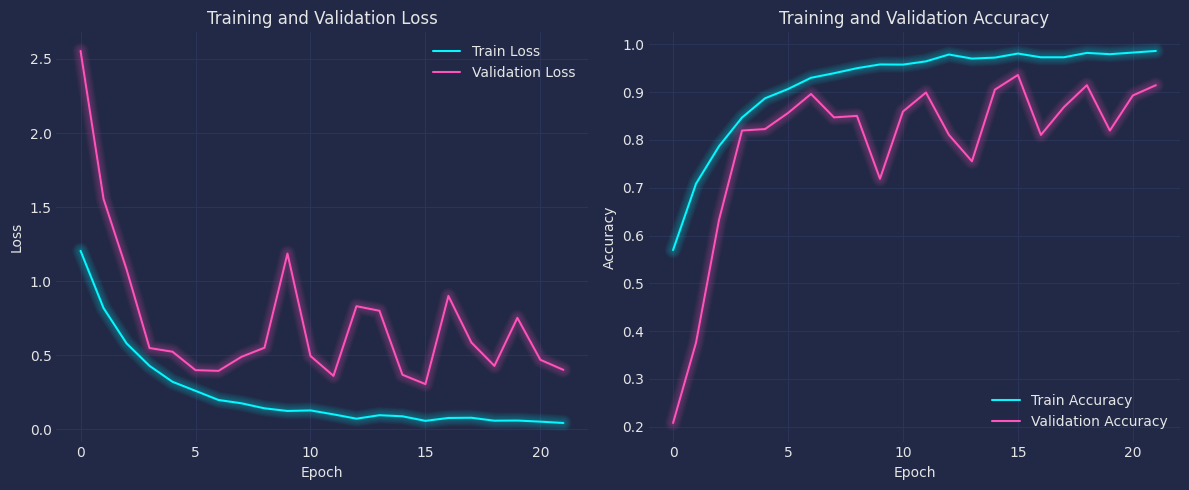

In [24]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


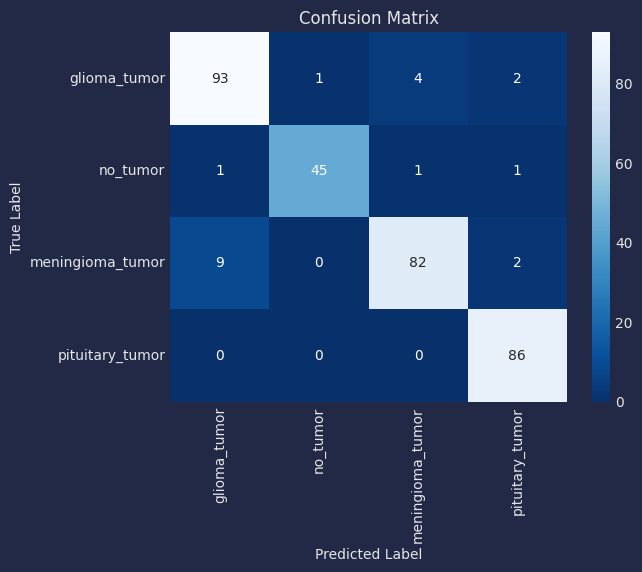

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       100
           1       0.98      0.94      0.96        48
           2       0.94      0.88      0.91        93
           3       0.95      1.00      0.97        86

    accuracy                           0.94       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.94      0.94      0.94       327



In [29]:
from IPython.display import FileLink

FileLink(r'best_23cnn.weights.h5')

/kaggle/working/best_23cnn.weights.h5

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

def predict(image_path):
    classifier_model='/kaggle/input/cnn23-brain-tumor/tensorflow1/cnn23-layers/1/best_23cnn.weights.h5'
    IMAGE_SHAPE=(512,512,3)
    model = cnn_model()
    model.load_weights(classifier_model)
    image = Image.open(image_path)
    test_image = image.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    test_image = np.array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    class_names = [
        "glioma_tumor",
        "no_tumor", 
        "meningioma_tumor", 
        "pituitary_tumor"
    ]
    predictions = model.predict(test_image)
    scores = tf.nn.softmax(predictions[0])
    scores = scores.numpy()
#     results = {
#         "glioma_tumor": 0, 
#         "no_tumor": 0, 
#         "meningioma_tumor": 0, 
#         "pituitary_tumor": 0
#     }
    
    results = f"{class_names[np.argmax(scores)]} with a { (100 * np.max(scores)).round(2) } % confidence."
    return results

In [22]:
image = "/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(10).jpg"
predictions = predict(image)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
pituitary_tumor with a 47.53 % confidence.
